### building blocks for formatting neuropix (sglx) data into kwd format. 


In [1]:
import numpy as np
import logging
import socket
import glob
import os
import matplotlib.pyplot as plt

from importlib import reload

#from intan2kwik import kwd

#mountainsort imports (for sorting)
#import mountainlab_pytools.mlproc as mlp
from pipefinch.pipeline import sglxutil as sglu
from pipefinch.h5tools.kwik import event as ev
from pipefinch.pipeline import filestructure as et

from pipefinch.neural.postsort import session



# Setup the logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)
        
logger.info('Logger set')
logger.info('Hostname {}'.format(socket.gethostname()))

2019-08-19 17:30:34,863 - root - INFO - Logger set
2019-08-19 17:30:34,865 - root - INFO - Hostname zpikezorter


#### read single sglx file

In [2]:
reload(et)

sess_par = {'bird': 'g4r4',
            'sess': '20190715_02',
           'probe': 'probe_0', # probe to sort ('probe_0', 'probe_1') (to lookup in the rig_par which port to extract)
           'sort': 1, 
           'epoch': None, # for the subfolder in the neuropix data}
           }

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sess_par['sort'])

sort_params = {'adjacency_radius': -1,
              'detect_threshold': 2,
              'freq_min': 600}

ds_params = {'detect_sign': -1}

ks_params = {'use_gpu': 1,
            'auto_merge': 1,
            'filt_per_chan': 4,
            }

# visualization default parameters
viz_par = { 'evt_name': 'motif',
           'evt_signal': 'trig_perceptron',
            'evt_edge': 1,
            'pre_ms': -500,
            'post_ms': 300,
            
            'pre_samples': 0,
            'post_samples': 0,
            'span': 0,
            }

# convenient paths
kwik_folder = exp_struct['folders']['kwik']
ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['raw']

In [3]:
exp_struct

{'folders': {'raw': '/mnt/microdrive/birds/g4r4/Ephys/raw/20190715_02',
  'kwik': '/data/experiment/microdrive/g4r4/Ephys/kwik/20190715_02',
  'msort': '/data/experiment/microdrive/g4r4/Ephys/msort/20190715_02',
  'ksort': '/data/experiment/microdrive/g4r4/Ephys/ksort/20190715_02'},
 'files': {'par': '/data/experiment/microdrive/g4r4/Ephys/ksort/20190715_02/params.json',
  'set': '/mnt/microdrive/birds/g4r4/Ephys/raw/20190715_02/settings.isf',
  'rig': '/mnt/microdrive/birds/g4r4/Ephys/raw/20190715_02/rig.json',
  'kwd': '/data/experiment/microdrive/g4r4/Ephys/kwik/20190715_02/stream.kwd',
  'kwik': '/data/experiment/microdrive/g4r4/Ephys/kwik/20190715_02/sort_1/spikes.kwik',
  'kwe': '/data/experiment/microdrive/g4r4/Ephys/kwik/20190715_02/events.kwe',
  'mda_raw': '/data/experiment/microdrive/g4r4/Ephys/msort/20190715_02/raw.mda',
  'bin_raw': '/data/experiment/microdrive/g4r4/Ephys/ksort/20190715_02/raw.bin'}}

### List all the sessions

In [4]:
reload(et)
all_bird_sess = et.list_sessions(sess_par['bird'])
#all_bird_sess

In [5]:
#sess_par['sess'] = all_bird_sess[-5]
sglu.list_sgl_epochs(sess_par)

['20190715_02_dir_g0',
 '20190715_02_undir_g0',
 '20190715_02_dir_0-0',
 '20190715_02_dir_0-1']

### generate the kwd file for the nidq chans

In [10]:
reload(sglu)
sglu.all_sgl_to_kwd(sess_par, include_blocks=['adc', 'dig_in'], overwrite=True)

2019-08-06 14:34:12,173 - pipefinch.pipeline.sglxutil - INFO - will process to kwd all epochs in session folder /mnt/microdrive/birds/g4r4/Ephys/raw/20190715_02
2019-08-06 14:34:12,174 - pipefinch.pipeline.sglxutil - INFO - found 3 epoch subfolders
2019-08-06 14:34:12,175 - pipefinch.pipeline.sglxutil - INFO - epoch folder /mnt/microdrive/birds/g4r4/Ephys/raw/20190715_02/20190715_02_dir_g0
2019-08-06 14:34:12,178 - pipefinch.pipeline.sglxutil - WARNING - File /data/experiment/microdrive/g4r4/Ephys/kwik/20190715_02/20190715_02_dir_g0/stream.kwd already exists
2019-08-06 14:34:12,179 - pipefinch.pipeline.sglxutil - INFO - Will create a new kwd file and overwrite the old one
2019-08-06 14:34:12,179 - pipefinch.pipeline.sglxutil - INFO - dest file: /data/experiment/microdrive/g4r4/Ephys/kwik/20190715_02/20190715_02_dir_g0/stream.kwd
2019-08-06 14:34:12,277 - pipefinch.pipeline.sglxutil - INFO - meta file /mnt/microdrive/birds/g4r4/Ephys/raw/20190715_02/20190715_02_dir_g0/20190715_02_dir_g0

In [6]:
reload(sglu)

<module 'pipefinch.pipeline.sglxutil' from '/home/ezequiel/repos/pipefinch/pipefinch/pipeline/sglxutil.py'>

### pick an epoch and get the dig events, align with analog signals
 - get the rig metadata (what probe, what channel name corresponds to the event)
 - get the kwd with the streams/events
 - get the raw data
 - do the alignments

get the rig metadata 

In [7]:
# rig_par = et.get_rig_par(exp_struct)
# rig_par

get the streams

In [8]:
exp_struct

{'folders': {'raw': '/mnt/microdrive/birds/g4r4/Ephys/raw/20190715_02',
  'kwik': '/data/experiment/microdrive/g4r4/Ephys/kwik/20190715_02',
  'msort': '/data/experiment/microdrive/g4r4/Ephys/msort/20190715_02',
  'ksort': '/data/experiment/microdrive/g4r4/Ephys/ksort/20190715_02'},
 'files': {'par': '/data/experiment/microdrive/g4r4/Ephys/ksort/20190715_02/params.json',
  'set': '/mnt/microdrive/birds/g4r4/Ephys/raw/20190715_02/settings.isf',
  'rig': '/mnt/microdrive/birds/g4r4/Ephys/raw/20190715_02/rig.json',
  'kwd': '/data/experiment/microdrive/g4r4/Ephys/kwik/20190715_02/stream.kwd',
  'kwik': '/data/experiment/microdrive/g4r4/Ephys/kwik/20190715_02/sort_1/spikes.kwik',
  'kwe': '/data/experiment/microdrive/g4r4/Ephys/kwik/20190715_02/events.kwe',
  'mda_raw': '/data/experiment/microdrive/g4r4/Ephys/msort/20190715_02/raw.mda',
  'bin_raw': '/data/experiment/microdrive/g4r4/Ephys/ksort/20190715_02/raw.bin'}}

In [9]:
sglu.list_sgl_epochs(sess_par)

['20190715_02_dir_g0',
 '20190715_02_undir_g0',
 '20190715_02_dir_0-0',
 '20190715_02_dir_0-1']

In [10]:
epoch = sglu.list_sgl_epochs(sess_par)[0]
reload(sglu)
epoch = sglu.list_sgl_epochs(sess_par)[0]
exp_struct = sglu.sgl_struct(sess_par, epoch)

In [11]:
kwd_path = exp_struct['files']['kwd']
reload(ev)
ttl = ev.TTL('ttl', 'DIN', kwd_path)
ttl.event_pd.head(10)

,rec,edge,ch_idx,t,ch
0,0,1,0,1308,DIN-00
1,0,1,1,3122,DIN-01
2,0,0,1,7122,DIN-01
3,0,0,0,11308,DIN-00
4,0,1,0,21309,DIN-00
5,0,1,1,30083,DIN-01
6,0,0,0,31309,DIN-00
7,0,0,1,34083,DIN-01
8,0,1,0,41309,DIN-00
9,0,0,0,51309,DIN-00


In [12]:
np.unique(ttl.event_pd['ch'])

array(['DIN-00', 'DIN-01', 'DIN-02'], dtype=object)

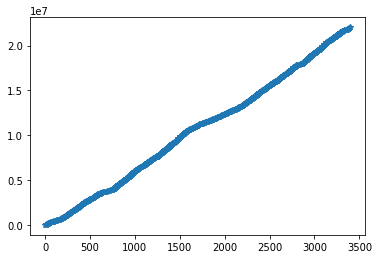

In [14]:
# this should bea straight line??
plt.plot(ttl.event_pd[(ttl.event_pd['ch']=='DIN-00') & (ttl.event_pd['edge']==0)]['t'], '*')

In [15]:
from pipefinch.h5tools.kwik import kwdfunctions as kwdf

kwdf.get_all_rec_meta(kwd_path)

,bit_depth,name,sample_rate,start_sample,start_time,channel_bit_volts,channel_names,channels_sample_rate,dig_channel_names,is_multiSampleRate_data,samples_count
0,16,0,20000.189453,0,2019-07-15 19:58:07,"[0.00030517578125, 0.00030517578125, 0.0003051...","[adc-00, adc-01, adc-02, adc-03, adc-04, adc-0...","[20000.190251, 20000.190251, 20000.190251, 200...","[DIN-00, DIN-01, DIN-02, DIN-03, DIN-04, DIN-0...",1,22060086


## Try with a session

In [16]:
reload(session)
sess_par.update({'epoch': epoch})
sess = session.SglSession(sess_par, viz_par)
sess.load_rig_par()
sess.load_mic_peri_event_streams()

2019-07-30 18:59:25,944 - pipefinch.pipeline.sglxutil - INFO - {'kwd': '/data/experiment/microdrive/g4r4/Ephys/kwik/20190715_02/20190715_02_dir_g0/streams.kwd', 'kwe': '/data/experiment/microdrive/g4r4/Ephys/kwik/20190715_02/20190715_02_dir_g0/events.kwe', 'mda_raw': '/data/experiment/microdrive/g4r4/Ephys/msort/20190715_02/20190715_02_dir_g0/raw.mda'}


In [17]:
mic_stream = sess.get_mic_stream()
mic_stream.shape

(48, 16000, 1)

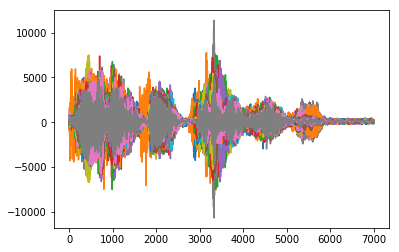

In [18]:
plt.plot(mic_stream.squeeze().T[9000:,:]);

In [19]:
viz_par

{'evt_name': 'motif',
 'evt_signal': 'trig_perceptron',
 'evt_edge': 1,
 'pre_ms': -500,
 'post_ms': 300,
 'pre_samples': -10000,
 'post_samples': 6000,
 'span': 16000}

### Check the syncronization signals

##### make the sgl file structure and retrieve bin and meta files

In [15]:
# in zpike
sess_folder = exp_struct['folders']['raw']

sgl_folder, sgl_pd = sglu.sgl_file_struct(sess_folder)

sgl_folder

{'nidq': '/mnt/microdrive/birds/g4r4/Ephys/raw/20190715_02/20190715_02_dir_g0',
 'imec': {0: '/mnt/microdrive/birds/g4r4/Ephys/raw/20190715_02/20190715_02_dir_g0/20190715_02_dir_g0_imec0'}}

In [16]:

probe_id = int(sess_par['probe'].split('_')[-1])

probe_data_folder = sgl_folder['imec'][probe_id]

ap_meta_files = glob.glob(os.path.join(probe_data_folder, '*.ap.meta'))

ap_meta_files

['/mnt/microdrive/birds/g4r4/Ephys/raw/20190715_02/20190715_02_dir_g0/20190715_02_dir_g0_imec0/20190715_02_dir_g0_t0.imec0.ap.meta']

##### read the meta and determine samplerate, number of channels, and channels

In [17]:
reload(sglu)
imec_meta_file_path = ap_meta_files[0]
# these should come from the .meta file

imec0_dict = sglu.get_imec_data(imec_meta_file_path)
n_chan = imec0_dict['meta']['nsavedchans'] #nSavedChans in meta file
s_f = imec0_dict['meta']['s_f'] #30000.533148 #imSampleRate in meta file
imec0_dict['meta']

{'acqaplfsy': '384,384,1',
 'appversion': '20190327',
 'filecreatetime': '2019-07-15T19:58:07',
 'filename': 'E:/data/birds/g4r4/Ephys/raw/20190715_02/20190715_02_dir_g0/20190715_02_dir_g0_imec0/20190715_02_dir_g0_t0.imec0.ap.bin',
 'filesha1': '3F8B757635B635DA9A4EC6637EDECE0F1D0C5DE7',
 'filesizebytes': '25479454000',
 'filetimesecs': '1103.0066666666667',
 'firstsample': '89247052',
 'gatemode': 'Immediate',
 'imairangemax': '0.6',
 'imairangemin': '-0.6',
 'imcalibrated': 'true',
 'imdatapi': '1.15',
 'imdatbs_fw': '1.1.128',
 'imdatbsc_fw': '1.0.151',
 'imdatbsc_hw': '2.1',
 'imdatbsc_pn': 'NP2_QBSC_00',
 'imdatbsc_sn': '478',
 'imdatfx_hw': '1.2',
 'imdatfx_pn': 'NP2_FLEX_0',
 'imdaths_fw': '5.1',
 'imdaths_pn': 'NP2_HS_30',
 'imdaths_sn': '1195',
 'imdatprb_pn': 'PRB_1_4_0480_1',
 'imdatprb_port': '1',
 'imdatprb_slot': '2',
 'imdatprb_sn': '18005112662',
 'imdatprb_type': '0',
 'imledenable': 'false',
 'imrofile': 'F:/SpikeGLX/Release_v20190327-phase3B2/SpikeGLX/imro_files/tipr

In [18]:
nidq_meta_files = glob.glob(os.path.join(sgl_folder['nidq'], '*.meta'))
meta_file_path = nidq_meta_files[0]
nidq_dict = sglu.get_ni_data(meta_file_path)
nidq_dict['meta']
nidq_syn_chan = 0

syn_chan = 0
nidq_dict['syn'] = nidq_dict['dig_in'][syn_chan]

2019-08-19 17:33:01,609 - pipefinch.pipeline.sglxutil - INFO - meta file /mnt/microdrive/birds/g4r4/Ephys/raw/20190715_02/20190715_02_dir_g0/20190715_02_dir_g0_t0.nidq.meta


##### memmap the file

#### The imec file.
Here's the meaning of some of the metadata https://github.com/JaneliaSciComp/JRCLUST/wiki/.meta-file.
In particular, there is an explanation of what channels in the probe are used and where they are located in the block.
More detailed meta here https://github.com/billkarsh/SpikeGLX/blob/master/Markdown/Metadata.md.

In [20]:
imec0 = sglu.get_imec_data(imec_meta_file_path)
n_chan = imec0['meta']['nsavedchans'] #nSavedChans in meta file
s_f = imec0['meta']['s_f'] #30000.533148 #imSampleRate in meta file

imec0['neural'].shape
# this yields an array shaped [n_ch, n_sample]

(385, 33090200)

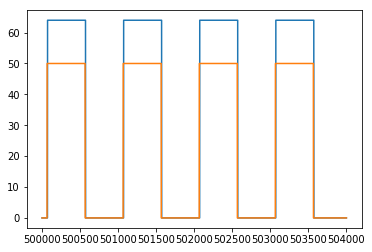

In [108]:
plot_ms = 2000
start_ms = 500000
end_ms = start_ms + 4000

imec_t_range = (imec0['t_ms'] > start_ms) & (imec0['t_ms'] < end_ms)
nidq_t_range = (nidq_dict['t_ms'] > start_ms) & (nidq_dict['t_ms'] < end_ms)

plt.plot(imec0['t_ms'][imec_t_range], imec0['syn'][imec_t_range])
plt.plot(nidq_dict['t_ms'][nidq_t_range], nidq_dict['syn'][nidq_t_range]*50)

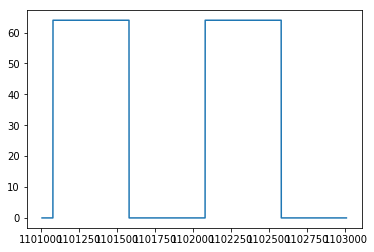

In [93]:
tail_sample = 2000*30
plt.plot(imec0['t_ms'][-tail_sample:], imec0['syn'][-tail_sample:])

(array([726.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 376.]),
 array([ 999.99048754,  999.99382084,  999.99715414, 1000.00048745,
        1000.00382075, 1000.00715405, 1000.01048735, 1000.01382065,
        1000.01715395, 1000.02048726, 1000.02382056]),
 <a list of 10 Patch objects>)

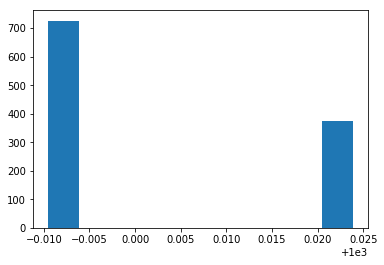

In [143]:
plot_ms = 1000*3600*12

syn_imec = imec0['syn'][imec0['t_ms']<plot_ms]
t_imec = imec0['t_ms'][imec0['t_ms']<plot_ms]*0.99999048754049
hi_imec = np.where(np.diff(syn_imec)>0)[0]
t_hi_imec = t_imec[1:][(np.diff(syn_imec)>0)]
np.unique(np.diff(t_hi_imec))
plt.hist(np.diff(t_hi_imec))

In [134]:
nidq_dict['meta']['nisamprate']

'20000.190251'

In [136]:
np.diff(np.where(np.diff(syn_imec)>0))/0.99999048754049

array([[30000.2853765 , 30000.2853765 , 30001.28538601, ...,
        30000.2853765 , 30000.2853765 , 30001.28538601]])

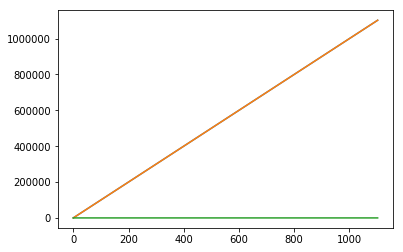

In [129]:
plt.plot(t_hi_imec)
plt.plot(t_hi_nidq)
plt.plot(t_hi_nidq - t_hi_imec)

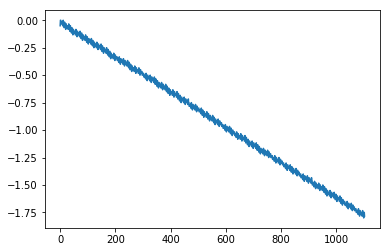

In [130]:
plt.plot(t_hi_nidq - t_hi_imec)

(array([886.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 216.]),
 array([ 999.99048754,  999.99548749, 1000.00048745, 1000.0054874 ,
        1000.01048735, 1000.0154873 , 1000.02048726, 1000.02548721,
        1000.03048716, 1000.03548711, 1000.04048707]),
 <a list of 10 Patch objects>)

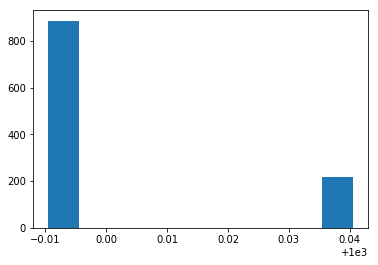

In [141]:
syn_nidq = nidq_dict['syn'][nidq_dict['t_ms']<plot_ms].astype(np.int)
t_nidq = nidq_dict['t_ms'][nidq_dict['t_ms']<plot_ms]
hi_nidq = np.where(np.diff(syn_nidq)>0)[0]
t_hi_nidq = t_nidq[1:][(np.diff(syn_nidq)>0)]
np.unique(np.diff(t_hi_nidq))
plt.hist(np.diff(t_hi_nidq))

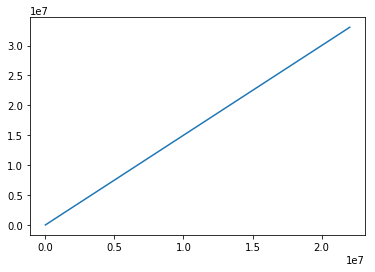

In [144]:
plt.plot(hi_nidq, hi_imec)

In [145]:
np.polyfit(hi_nidq, hi_imec, 1)

array([1.5000024, 0.9901971])

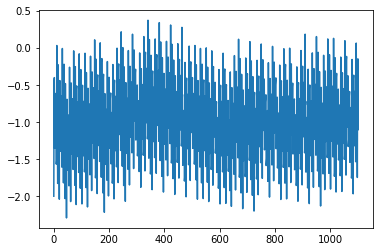

In [146]:
plt.plot(hi_nidq*1.5000024 - hi_imec)

In [148]:
np.float(18000000/12000114)

1.4999857501353737

In [131]:
np.median(np.diff(t_hi_nidq))/np.median(np.diff(t_hi_imec))

1.0

12000114
18000000


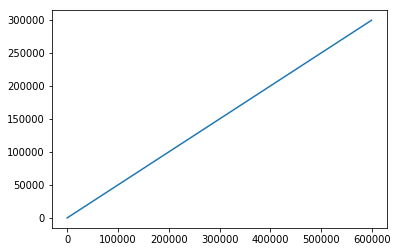

In [38]:
## Check alignment of syn signals
def high_times(x, s_f, t_max):
    n_max = int(t_max*s_f)
    print(n_max)
    return np.where(np.diff(x[:n_max])>0)[0]/s_f * 1000

t_max = 600
hi_nidq = high_times(nidq_dict['syn'], nidq_dict['meta']['s_f'], t_max)
hi_imec = high_times(imec0['syn'], imec0['meta']['s_f'], t_max)

plt.plot(hi_imec, hi_nidq[:hi_imec.size])

In [124]:
imec0['meta']['s_f']/(18000000/12000114)

20000.19

In [125]:
nidq_dict['meta']['s_f']

20000.190251

In [41]:
30000nidq_dict['meta']['s_f']

1.4999857313107317

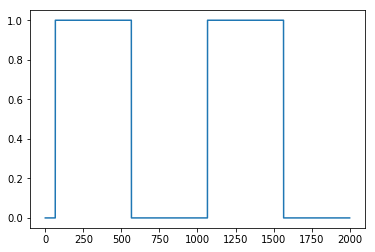

In [35]:
plt.plot(nidq_dict['t_ms'][nidq_dict['t_ms']<plot_ms], nidq_dict['syn'][nidq_dict['t_ms']<plot_ms])

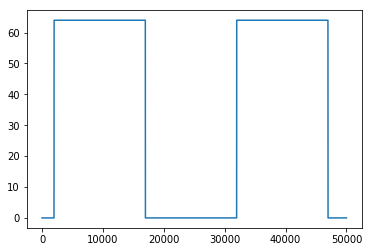

In [28]:
plt.plot(imec0['syn'][:50000])

In [42]:
high = np.where(np.diff(imec0['syn'][:500000])>0)[0]
high

array([  1964,  31964,  61964,  91965, 121965, 151965, 181966, 211966,
       241966, 271967, 301967, 331967, 361968, 391968, 421969, 451969,
       481969])

#### same for the nidq file
More detailed meta here https://github.com/billkarsh/SpikeGLX/blob/master/Markdown/Metadata.md.
- 

##### Plot the digital channels

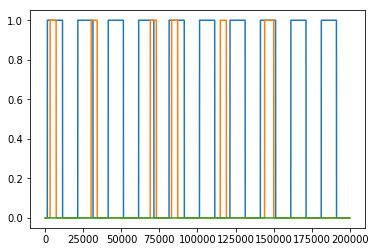

In [34]:
all_dig_stream = nidq_dict['dig_in']
syn_chan = 0

plt.plot(all_dig_stream[0, :20000*10])
plt.plot(all_dig_stream[1, :20000*10])
plt.plot(all_dig_stream[2, :20000*10])

In [35]:
all_dig_stream = nidq_dict['dig_in']
syn_chan = 0

##### Plot the microphone channels

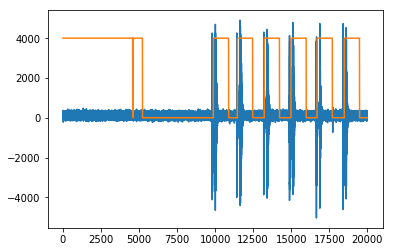

In [14]:
# plot mic chan together with the dig_in trigger channel
mic_chan = 0
plot_ms = 20000

# the trigger channel
trig_chan = 1

t_ms_nidq = nidq['t_ms']
data_nidq = nidq['adc']
plt.plot(t_ms_nidq[t_ms_nidq<plot_ms], data_nidq[mic_chan, t_ms_nidq<plot_ms])
plt.plot(t_ms_nidq[t_ms_nidq<plot_ms], nidq['din'][trig_chan, t_ms_nidq<plot_ms]*4000)

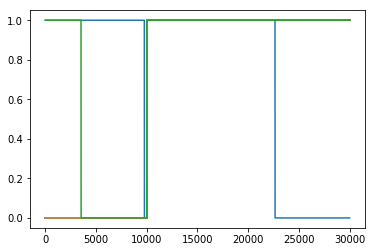

In [15]:
## get all the wavs aligned with the digital triggers
trig_chan = 1
trig_samples = np.where(np.diff(nidq['din'][trig_chan])==1)[0]

samp_pre = -10000
samp_post = 20000

d_frames_3d = sglu.quick_frames(nidq['din'], trig_samples, samp_pre, samp_post)
plt.plot(d_frames_3d[1, :, :].T);

##### now go for the analogs

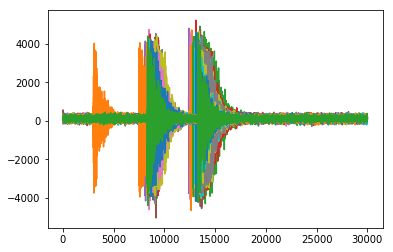

In [16]:
adc_frames_3d = sglu.quick_frames(nidq['adc'], trig_samples, samp_pre, samp_post)
plt.plot(adc_frames_3d[0, :, :].T);

## to do: same for imecs
 - do the align
 - compute the CAR, rms, threshold for all.
 - get channel maps and select the ones who are responsive

### Imec and nidq data sync check
Check that the sync channels are aligned (meaning the timestamps in both files make sense)

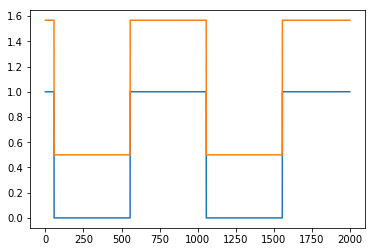

In [17]:
# plot the syn channels syde by side
plot_ms = 2000
syn_dig_in = 0 #digital channel in the nidaq used for syn

plt.plot(nidq['t_ms'][nidq['t_ms']<plot_ms], nidq['din'][syn_dig_in, nidq['t_ms']<plot_ms])
plt.plot(imec0['t_ms'][imec0['t_ms']<plot_ms], imec0['syn'][imec0['t_ms']<plot_ms]/60+0.5)

### convert timestamps from one to the other
- The trigger timestamps are in nidq sampling rate. These need to be rescaled to imec sampling rate. 
So do the windows.


In [18]:
trigger_stamps_ni = trig_samples
trigger_stamps_im = (trigger_stamps_ni / nidq['meta']['s_f'] * imec0['meta']['s_f']).astype(np.int)

samp_pre_im = int(samp_pre / nidq['meta']['s_f'] * imec0['meta']['s_f'])
samp_post_im = int(samp_post / nidq['meta']['s_f'] * imec0['meta']['s_f'])

neural_frames_3d = sglu.quick_frames(imec0['neural'], trigger_stamps_im, samp_pre_im, samp_post_im)
syn_frames_3d = sglu.quick_frames(np.expand_dims(imec0['syn'], axis=0), trigger_stamps_im, samp_pre_im, samp_post_im)

### plot the first trigger and the syn signal of both nidq and imec datam

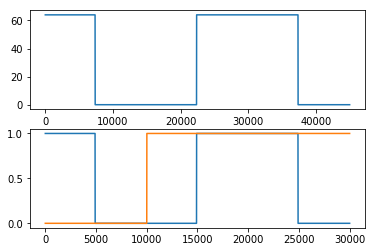

In [19]:
i_trig = 10

plt.subplot(211)
plt.plot(syn_frames_3d[0, i_trig,:])
plt.subplot(212)
plt.plot(d_frames_3d[0, i_trig,:])
plt.plot(d_frames_3d[1, i_trig,:])

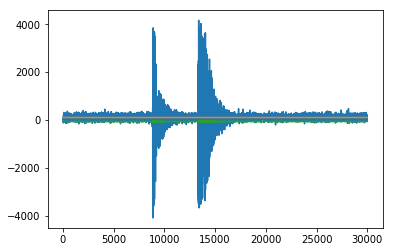

In [20]:
plt.plot(adc_frames_3d[:3, i_trig, :].T);

In [21]:
### do the car
### get peaks
#get peaks histo
#decide criterion for activity
#select ative chanes

In [22]:
z = adc_frames_3d[:3, i_trig, :] + 500
z.shape

(3, 30000)

In [23]:
np.mean(z, axis=1)

array([607.47513333, 601.97056667, 433.8627    ])

In [ ]:
from numba import jit
from pipefinch.util import jitarray as jita
reload(jita)

@jit(parallel=True)
def slow_car(x: np.array, ch_axis: int=0) -> np.ndarray:
    # remove offset
    sample_axis = (ch_axis + 1)%2
    y = x - np.expand_dims(np.median(x, axis=sample_axis), axis=1)
    return y

@jit(nopython=True, parallel=True)
def fast_offset(x: np.array) -> np.ndarray:
    # remove offset
    n_chan, n_sample = x.shape
    y = np.empty(x.shape)
    for i in np.arange(n_chan):
        y[i, :] = x[i, :] - np.mean(x[i, :])
    return y

@jit(nopython=True, parallel=True)
def fast_median_substract(x: np.array) -> np.ndarray:
    # remove common average (median) across col
    n_chan, n_sample = x.shape
    y = np.empty(x.shape)
    for i in np.arange(n_chan):
        y[i, :] = x[i, :] - np.median(x[i, :])
    return y


@jit(nopython=True, parallel=True)
def chunked_postprocess(raw_arr: np.array, post_arr:np.array, chunk_size=80000) -> np.ndarray:
    #postprocess:
    # pre and post are ready to be memmaped, for super large files
    # per chunk: 
    #  - remove offset
    #  - do CAR
    #  - filter?
    assert(raw_arr.shape == post_arr.shape), 'data array and post_array holder must be same shape'
    n_chan, n_sample = raw_arr.shape
    n_chunk = n_sample//chunk_size + 1
    print('Postprocessing file length ', n_sample)
    print('Total chunks: ', n_chunk)
    for i in np.arange(n_chunk):
        if not i%10:
            print('chunk', i, '/', n_chunk)
        chunk_start = i * chunk_size
        chunk_end = (i + 1) * chunk_size
        if chunk_end > n_sample:
            chunk_end = n_sample
        # fist do offset remove
        chunk_arr = jita.substract_mean_col(raw_arr[:, chunk_start:chunk_end])
        # now do CAR (mean substract along channels axis)
        post_arr[:, chunk_start:chunk_end] = jita.substract_mean_col(chunk_arr.T).T
    print('Done postprocessing')
    return post_arr
    
def postprocess_neural(meta_file_path: str):
    imec = sglu.get_imec_data(meta_file_path)
    bin_file_path = sglu.get_data_meta_path(meta_file_path)[0]
    logger.info('preprocessing file '.format({meta_file_path}))
    post_file_path = bin_file_path + '.car'
    
    data = imec['neural'] # this is a memmaped file
    logger.info('raw bin file has {} samples'.format(data.shape[1]))
    logger.info('Creating pre-processed file {}'.format(post_file_path))
    post_data = np.memmap(post_file_path, dtype=data.dtype, mode='w+', shape=data.shape)
    post_data = chunked_postprocess(data, post_data)
    logger.info('done')
    return(post_data)
    
#y = chunked_postprocess(z, np.empty(z.shape))
data_post = postprocess_neural(imec_meta_file_path)

2019-06-05 20:47:26,167 - root - INFO - preprocessing file 
2019-06-05 20:47:26,168 - root - INFO - raw bin file has 1695813 samples
2019-06-05 20:47:26,169 - root - INFO - Creating pre-processed file /Users/zeke/experiment/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/2019-05-27_stimsim_0000_00_g0_imec0/2019-05-27_stimsim_0000_00_g0_t0.imec0.ap.bin.car


Postprocessing file length  1695813
Total chunks:  21
chunk 0 / 22


In [78]:
print('chunk', i, '/' , 10)

chunk 10 / 10


In [69]:
imec0['car'] = data_post

In [75]:
i=10
'chunk %i'%i

'chunk 10'

In [62]:
data_post.shape

(385, 1695813)

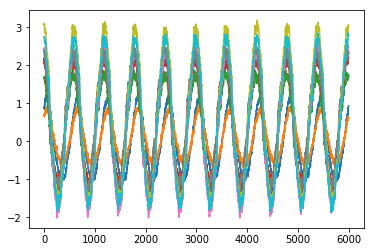

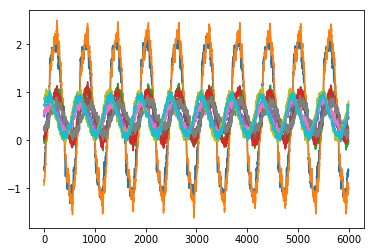

In [72]:
plot_ms=200
plt.plot(imec0['neural'][0:10, imec0['t_ms']<plot_ms].T/60+0.5)
plt.figure()
plt.plot(imec0['car'][0:10, imec0['t_ms']<plot_ms].T/60+0.5)

In [ ]:
print('tu vieja )

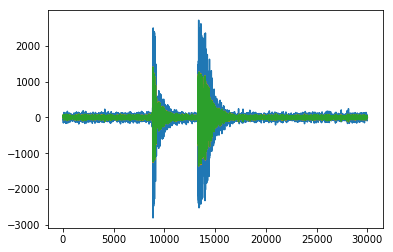

In [52]:
plt.plot(y.T)

In [51]:
z[:30000]

array([[596, 588, 576, ..., 614, 595, 595],
       [603, 602, 602, ..., 602, 602, 602],
       [440, 440, 440, ..., 440, 440, 441]], dtype=int16)

In [38]:
z.shape

(3, 30000)

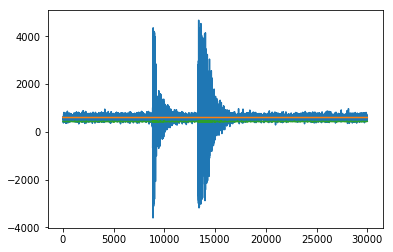

In [31]:
plt.plot(z.T);

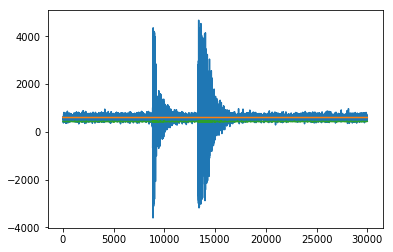

In [25]:
plt.plot(z.T)

In [28]:
np.mean(z, axis=1)

array([607.47513333, 601.97056667, 433.8627    ])

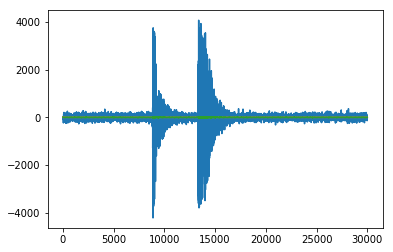

In [52]:
plt.plot(y.T)

In [53]:
import timeit
%timeit slow_car(z)

721 µs ± 23.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
